## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Import libraries

In [1]:
import helpers

from helpers import np
from helpers import glob
from helpers import cv2
from helpers import plt
from helpers import mpimg
from helpers import pickle
from helpers import os

%matplotlib inline

## Function to calibrate the camera

In [2]:
def calibrateCamera(imgpath, nx, ny, calibrationfile):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(imgpath)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
            dist_pickle = {}
            dist_pickle["objpoints"] = objpoints
            dist_pickle["imgpoints"] = imgpoints
            pickle.dump(dist_pickle, open(calibrationfile, "wb"))

    cv2.destroyAllWindows()

In [ ]:
# Example code
calibrateCamera('camera_cal/calibration*.jpg', 9, 6, "wide_dist_pickle.p")

## Undistort image function

In [3]:
def undistortImage(img, calibrationfile):
    if(os.path.isfile(calibrationfile)):
        # Read in the saved objpoints and imgpoints
        dist_pickle = pickle.load(open(calibrationfile, "rb"))
        objpoints = dist_pickle["objpoints"]
        imgpoints = dist_pickle["imgpoints"]

        # Do camera calibration given object points and image points
        img_size = (img.shape[1], img.shape[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

        # Undistort the image
        undist = cv2.undistort(img, mtx, dist, None, mtx)
    else:
        undist = img

    return undist

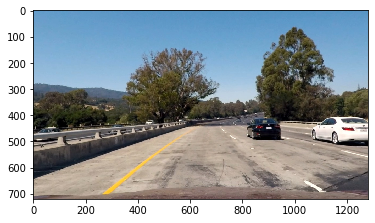

In [4]:
# Example code
img = plt.imread('test_images/test1.jpg')
undist = undistortImage(img, "wide_dist_pickle.p")
plt.imshow(undist)

## Function to get the perspective change matrixes

In [5]:
def getPerspectiveMatrix():
    # Define source and destination points
    # Considered line is about 20m length and 3.7m width
    src = np.float32([ [707, 462], [1043, 672], [275, 677], [578, 462] ])
    # 720 px length = 20m, 800 px width = 3.7m 
    dst = np.float32([ [1040, 0], [1040, 719], [240, 719], [240, 0] ])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Get and return M
    return M, Minv

In [6]:
# Example code
M, Minv = getPerspectiveMatrix()

## Thresholding functions to be combined

In [7]:
def sobelThreshold(img, orient = 'x', channel = 'R', sobel_kernel = 3, thresh = (0, 255)):
    if channel == 'R':
        img_channel = img[:,:,0]
    elif channel == 'G':
        img_channel = img[:,:,1]
    elif channel == 'H':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,0]    
    elif channel == 'S':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,2]
    else:
        img_channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel))

    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)

    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def magThreshold(img, channel = 'R', sobel_kernel = 3, thresh = (0, 255)):
    if channel == 'R':
        img_channel = img[:,:,0]
    elif channel == 'G':
        img_channel = img[:,:,1]
    elif channel == 'H':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,0]    
    elif channel == 'S':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,2]
    else:
        img_channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)

    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def dirThreshold(img, channel = 'R', sobel_kernel=3, thresh = (0, np.pi/2)):
    if channel == 'R':
        img_channel = img[:,:,0]
    elif channel == 'G':
        img_channel = img[:,:,1]
    elif channel == 'H':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,0]    
    elif channel == 'S':    
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
        img_channel = hls[:,:,2]
    else:
        img_channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

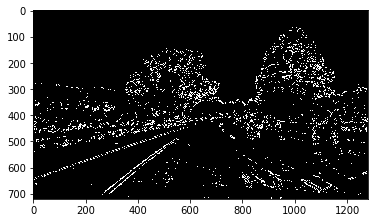

In [8]:
# Example code
sx = sobelThreshold(undist, 'x', 'R', 9, thresh = (20, 100))
sy = sobelThreshold(undist, 'y', 'R', 9, thresh = (20, 100))
magthr = magThreshold(undist, 'R', 9, thresh = (30, 100))
dirthr = dirThreshold(undist, 'R', 15, (0.7, 1.3))

gr_binary = np.zeros_like(sx)
gr_binary[((sx == 1) & (sy == 1)) | ((magthr == 1) & (dirthr == 1))] = 1

plt.imshow(gr_binary, cmap = 'gray')

## Color transform function

In [9]:
def color_select(img):
    LOW_WHITE = np.array([0, 0, 223], dtype=np.uint8)
    HIGH_WHITE = np.array([90,63,255], dtype=np.uint8)
    LOW_YELLOW = np.array([15,127,223], dtype=np.uint8)
    HIGH_YELLOW = np.array([30,255,255], dtype=np.uint8)

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    wmask = cv2.inRange(hsv, LOW_WHITE, HIGH_WHITE)//255
    ymask = cv2.inRange(hsv, LOW_YELLOW, HIGH_YELLOW)//255
    binary_output = cv2.bitwise_or(ymask, wmask)
    
    return binary_output

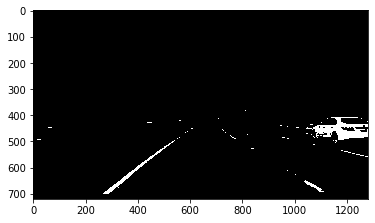

In [10]:
# Example code
color_binary = color_select(undist)
plt.imshow(color_binary, cmap = 'gray')

## Combine the gradient and the color transformed images

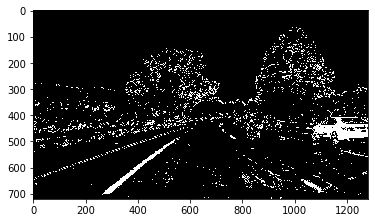

In [11]:
combined_binary = np.zeros_like(color_binary)
combined_binary[(color_binary == 1) | (gr_binary == 1)] = 1

plt.imshow(combined_binary, cmap = 'gray')

## Warp image

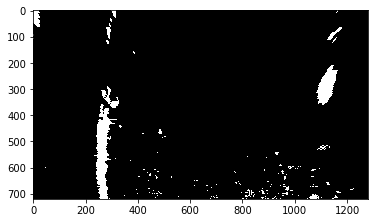

In [12]:
# Example code
binary_warped = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]))
plt.imshow(binary_warped, cmap = 'gray')

## Lane finder and polynomial fit functions

In [13]:
# Function to find the line and fit the polynomial of the first considered frame
def findLines(binary_warped, nwindows = 9, margin = 100, minpix = 50, visualization = False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Compute distance from the center of the lane
    midlane = np.int(np.mean([leftx_base, rightx_base]))

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, left_fitx, ploty = helpers.fit_poly(binary_warped.shape, leftx, lefty)
    right_fit, right_fitx, ploty = helpers.fit_poly(binary_warped.shape, rightx, righty)
    
    left_curv = helpers.compute_curvature(binary_warped, leftx, lefty)
    right_curv = helpers.compute_curvature(binary_warped, rightx, righty)
    
    xm_per_pix = 3.7 / 800
    distance = (midpoint - midlane) * xm_per_pix
    
    # Visualization
    if(visualization == True):
        helpers.line_visualization(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, margin)
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty, left_curv, right_curv, distance

In [14]:
# Example code
left_fit, right_fit, left_fitx, right_fitx, ploty, left_curv, right_curv, distance = findLines(binary_warped, True)

## Drawing

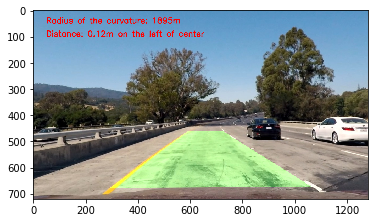

In [15]:
curv = np.mean([left_curv, right_curv])

# Example code
result = helpers.drawLane(undist, binary_warped, ploty, left_fitx, right_fitx, curv, distance, Minv)
plt.imshow(result)

## Pipeline

In [28]:
class LaneFinder():
    def __init__(self):
        self.__left_fit = []
        self.__right_fit = []
        self.__left_fitx = []
        self.__right_fitx = []
        self.__ploty = []
        self.__left_curv = 0
        self.__right_curv = 0
        self.__distance = 0.0
        
    def __setAttributes(self, left_fit, right_fit, left_fitx, right_fitx, ploty, left_curv, right_curv, distance):
        self.__left_fit = left_fit
        self.__right_fit = right_fit
        self.__left_fitx = left_fitx
        self.__right_fitx = right_fitx
        self.__ploty = ploty
        self.__left_curv = left_curv
        self.__right_curv = right_curv
        self.__distance = distance
        
    def __sanityCheck(self, left_fitx, right_fitx, left_curv, right_curv):
        right_curvature = (left_curv > 100) and (right_curv > 100)
        distance = np.absolute(np.mean(left_fitx) - np.mean(right_fitx))
        right_distance = distance > 700 and distance < 900
        
        return right_curvature and right_distance

    def processImage(self, img):
        # Undistort the image
        undist = undistortImage(img, "wide_dist_pickle.p")

        # Apply gradient thresholding
        sx = sobelThreshold(undist, 'x', 'R', 9, thresh = (20, 100))
        sy = sobelThreshold(undist, 'y', 'R', 9, thresh = (20, 100))
        magthr = magThreshold(undist, 'R', 9, thresh = (30, 100))
        dirthr = dirThreshold(undist, 'R', 15, (0.7, 1.3))

        gr_binary = np.zeros_like(sx)
        gr_binary[((sx == 1) & (sy == 1)) | ((magthr == 1) & (dirthr == 1))] = 1

        # Apply color thresholding on S channel
        color_binary = color_select(undist)

        # Combine gradient and color thresholding
        combined_binary = np.zeros_like(color_binary)
        combined_binary[(color_binary == 1) | (gr_binary == 1)] = 1

        # Warp image
        binary_warped = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]))
        
        try:
            left_fit, right_fit, left_fitx, right_fitx, ploty, left_curv, right_curv, distance = \
            findLines(binary_warped)
            if(self.__sanityCheck(left_fitx, right_fitx, left_curv, right_curv)):
                self.__setAttributes(left_fit, right_fit, left_fitx, right_fitx, ploty, left_curv, right_curv, distance)
            else:
                print('no sanity')
        except:
            print('undetected line')
            
        # Draw lane
        curv = np.mean([self.__left_curv, self.__right_curv])
        result = helpers.drawLane(undist, binary_warped, self.__ploty, self.__left_fitx, self.__right_fitx,
                                  curv, self.__distance, Minv)

        return result

## Apply pipeline on images

In [29]:
input_folder = 'test_images/'
output_folder = 'output_images/'

for fname in os.listdir(input_folder):
    lf = LaneFinder()
    
    # Read the image
    img = plt.imread(input_folder + fname)
    # Apply the pipeline
    result = lf.processImage(img)
    # Save the image
    plt.imsave(output_folder + fname, result)

## Include libraries for videos

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Apply the pipeline on project video

In [25]:
lf = LaneFinder()

white_output = 'output_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lf.processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


  5%|▍         | 59/1261 [00:18<06:13,  3.22it/s]

no sanity


  8%|▊         | 96/1261 [00:29<05:36,  3.46it/s]

no sanity


 13%|█▎        | 162/1261 [00:50<05:24,  3.39it/s]

no sanity


 25%|██▍       | 314/1261 [01:37<05:30,  2.87it/s]

no sanity


 25%|██▌       | 316/1261 [01:38<04:57,  3.17it/s]

no sanity


 25%|██▌       | 318/1261 [01:38<05:03,  3.11it/s]

no sanity


 25%|██▌       | 319/1261 [01:39<05:34,  2.81it/s]

no sanity


 25%|██▌       | 320/1261 [01:39<05:44,  2.73it/s]

no sanity


 26%|██▌       | 322/1261 [01:40<05:03,  3.09it/s]

no sanity


 26%|██▌       | 324/1261 [01:40<04:52,  3.20it/s]

no sanity


 26%|██▌       | 329/1261 [01:42<04:39,  3.34it/s]

no sanity


 26%|██▌       | 330/1261 [01:42<04:52,  3.19it/s]

no sanity


 26%|██▌       | 331/1261 [01:43<05:17,  2.93it/s]

no sanity


 27%|██▋       | 344/1261 [01:47<04:37,  3.31it/s]

no sanity


 28%|██▊       | 352/1261 [01:50<05:13,  2.90it/s]

no sanity


 28%|██▊       | 358/1261 [01:52<04:50,  3.11it/s]

no sanity


 28%|██▊       | 359/1261 [01:52<05:02,  2.98it/s]

no sanity


 29%|██▊       | 361/1261 [01:53<04:47,  3.13it/s]

no sanity


 29%|██▉       | 364/1261 [01:54<04:32,  3.29it/s]

no sanity


 29%|██▉       | 367/1261 [01:55<04:46,  3.12it/s]

no sanity


 29%|██▉       | 368/1261 [01:55<04:27,  3.34it/s]

no sanity


 30%|██▉       | 377/1261 [01:58<04:21,  3.39it/s]

no sanity


 30%|██▉       | 378/1261 [01:58<04:29,  3.28it/s]

no sanity


 30%|███       | 381/1261 [01:59<04:28,  3.28it/s]

no sanity


 31%|███       | 385/1261 [02:00<04:38,  3.15it/s]

no sanity


 31%|███       | 386/1261 [02:01<05:07,  2.84it/s]

no sanity


 32%|███▏      | 403/1261 [02:06<04:19,  3.31it/s]

no sanity


 32%|███▏      | 406/1261 [02:07<04:57,  2.88it/s]

no sanity


 32%|███▏      | 407/1261 [02:07<04:39,  3.06it/s]

no sanity


 33%|███▎      | 415/1261 [02:10<04:59,  2.82it/s]

no sanity


 33%|███▎      | 421/1261 [02:12<05:02,  2.78it/s]

no sanity


 34%|███▍      | 427/1261 [02:14<04:58,  2.80it/s]

no sanity


 34%|███▍      | 428/1261 [02:15<04:53,  2.83it/s]

no sanity


 34%|███▍      | 429/1261 [02:15<04:48,  2.89it/s]

no sanity


 34%|███▍      | 430/1261 [02:15<04:42,  2.94it/s]

no sanity


 34%|███▍      | 431/1261 [02:15<04:37,  2.99it/s]

no sanity


 35%|███▍      | 437/1261 [02:18<04:30,  3.04it/s]

no sanity


 35%|███▍      | 439/1261 [02:18<04:46,  2.87it/s]

no sanity


 35%|███▍      | 440/1261 [02:19<04:39,  2.94it/s]

no sanity


 35%|███▌      | 442/1261 [02:19<04:11,  3.25it/s]

no sanity


 35%|███▌      | 445/1261 [02:20<04:31,  3.01it/s]

no sanity


 36%|███▌      | 454/1261 [02:23<04:37,  2.91it/s]

no sanity


 36%|███▌      | 456/1261 [02:24<04:30,  2.97it/s]

no sanity


 37%|███▋      | 469/1261 [02:28<04:10,  3.16it/s]

no sanity


 38%|███▊      | 482/1261 [02:32<04:20,  2.99it/s]

no sanity


 39%|███▊      | 488/1261 [02:34<04:14,  3.03it/s]

no sanity


 39%|███▉      | 498/1261 [02:38<04:20,  2.93it/s]

no sanity


 40%|███▉      | 499/1261 [02:38<04:13,  3.00it/s]

no sanity


 41%|████      | 516/1261 [02:44<04:33,  2.73it/s]

no sanity


 41%|████      | 517/1261 [02:44<04:28,  2.77it/s]

no sanity


 41%|████      | 518/1261 [02:45<04:10,  2.96it/s]

no sanity


 41%|████▏     | 523/1261 [02:46<04:08,  2.97it/s]

no sanity


 42%|████▏     | 531/1261 [02:49<04:01,  3.02it/s]

no sanity


 43%|████▎     | 541/1261 [02:52<03:56,  3.04it/s]

no sanity


 44%|████▍     | 554/1261 [02:57<03:43,  3.17it/s]

no sanity


 44%|████▍     | 560/1261 [02:59<03:44,  3.12it/s]

no sanity


 64%|██████▍   | 806/1261 [04:17<02:25,  3.12it/s]

no sanity


 64%|██████▍   | 809/1261 [04:18<02:17,  3.28it/s]

no sanity


 67%|██████▋   | 847/1261 [04:30<02:04,  3.32it/s]

no sanity


 68%|██████▊   | 858/1261 [04:33<02:11,  3.05it/s]

no sanity


 74%|███████▎  | 928/1261 [04:55<01:48,  3.07it/s]

no sanity


 76%|███████▌  | 954/1261 [05:04<01:36,  3.18it/s]

no sanity


 79%|███████▊  | 992/1261 [05:15<01:26,  3.12it/s]

no sanity


 79%|███████▉  | 995/1261 [05:16<01:15,  3.53it/s]

no sanity


 79%|███████▉  | 1001/1261 [05:18<01:23,  3.10it/s]

no sanity


 85%|████████▌ | 1072/1261 [05:41<00:58,  3.22it/s]

no sanity


 89%|████████▉ | 1124/1261 [05:57<00:42,  3.21it/s]

no sanity


 90%|█████████ | 1141/1261 [06:02<00:37,  3.22it/s]

no sanity


 93%|█████████▎| 1174/1261 [06:13<00:24,  3.50it/s]

no sanity


 95%|█████████▌| 1199/1261 [06:20<00:18,  3.44it/s]

no sanity


 95%|█████████▌| 1200/1261 [06:21<00:17,  3.50it/s]

no sanity


 96%|█████████▌| 1208/1261 [06:23<00:17,  3.07it/s]

no sanity


 98%|█████████▊| 1240/1261 [06:33<00:06,  3.06it/s]

no sanity


 99%|█████████▉| 1247/1261 [06:36<00:05,  2.70it/s]

no sanity


 99%|█████████▉| 1254/1261 [06:38<00:02,  2.95it/s]

no sanity


100%|█████████▉| 1255/1261 [06:38<00:01,  3.07it/s]

no sanity


100%|█████████▉| 1256/1261 [06:39<00:01,  3.26it/s]

no sanity


100%|█████████▉| 1260/1261 [06:40<00:00,  3.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 36min 15s, sys: 58.1 s, total: 37min 13s
Wall time: 6min 41s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Apply the pipeline on challenge video

In [ ]:
lf = LaneFinder()

white_output = 'output_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(lf.processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Apply the pipeline on harder challenge video

In [ ]:
lf = LaneFinder()

white_output = 'output_harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(lf.processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))